# Benchmark dataset creator

Léa Bouffaut, Ph.D. -- K. Lisa Yang Center for Conservation Bioacoustics, Cornell University

lea.bouffaut@cornell.edu

### Motivations and objectives
Many bioacoustic projects are sitting on a goldmine of already annotated datasets. We want to create a standardized pipeline for creating, storing, sharing and
using data that is flexible and repeatable  to train and test AI models for different applications. More details in https://www.overleaf.com/read/yfcgvngmwfbs#e349e7

This notebook aims to create a benchmark dataset and standardize the following:
* File duration
* Sampling frequency
* Mono channel
* Bit depth
* File name format
* Selection table fields

It also gives the option to change labels, e.g., to match our standardized label format.


<b>It does NOT:</b>
* Filter the audio input beyond what is needed for resampling
* Normalize the audio file amplitude

For example, this schematic view presents (top) a Raven Pro project with a selection table associated with several audio files of different lengths, (bottom) the standardized benchmark clips, and associated annotations. Note that annotations at the junction between two export files and those in the remaining audio, which are too short in comparison with the selected export audio file duration, are ignored.For example, this schematic view presents (top) a Raven Pro project with a selection table associated with several audio files of different lengths, (bottom) the standardized benchmark clips, and associated annotations. Note that annotations at the junction between two export files and those in the remaining audio, which are too short in comparison with the selected export audio file duration, are ignored.
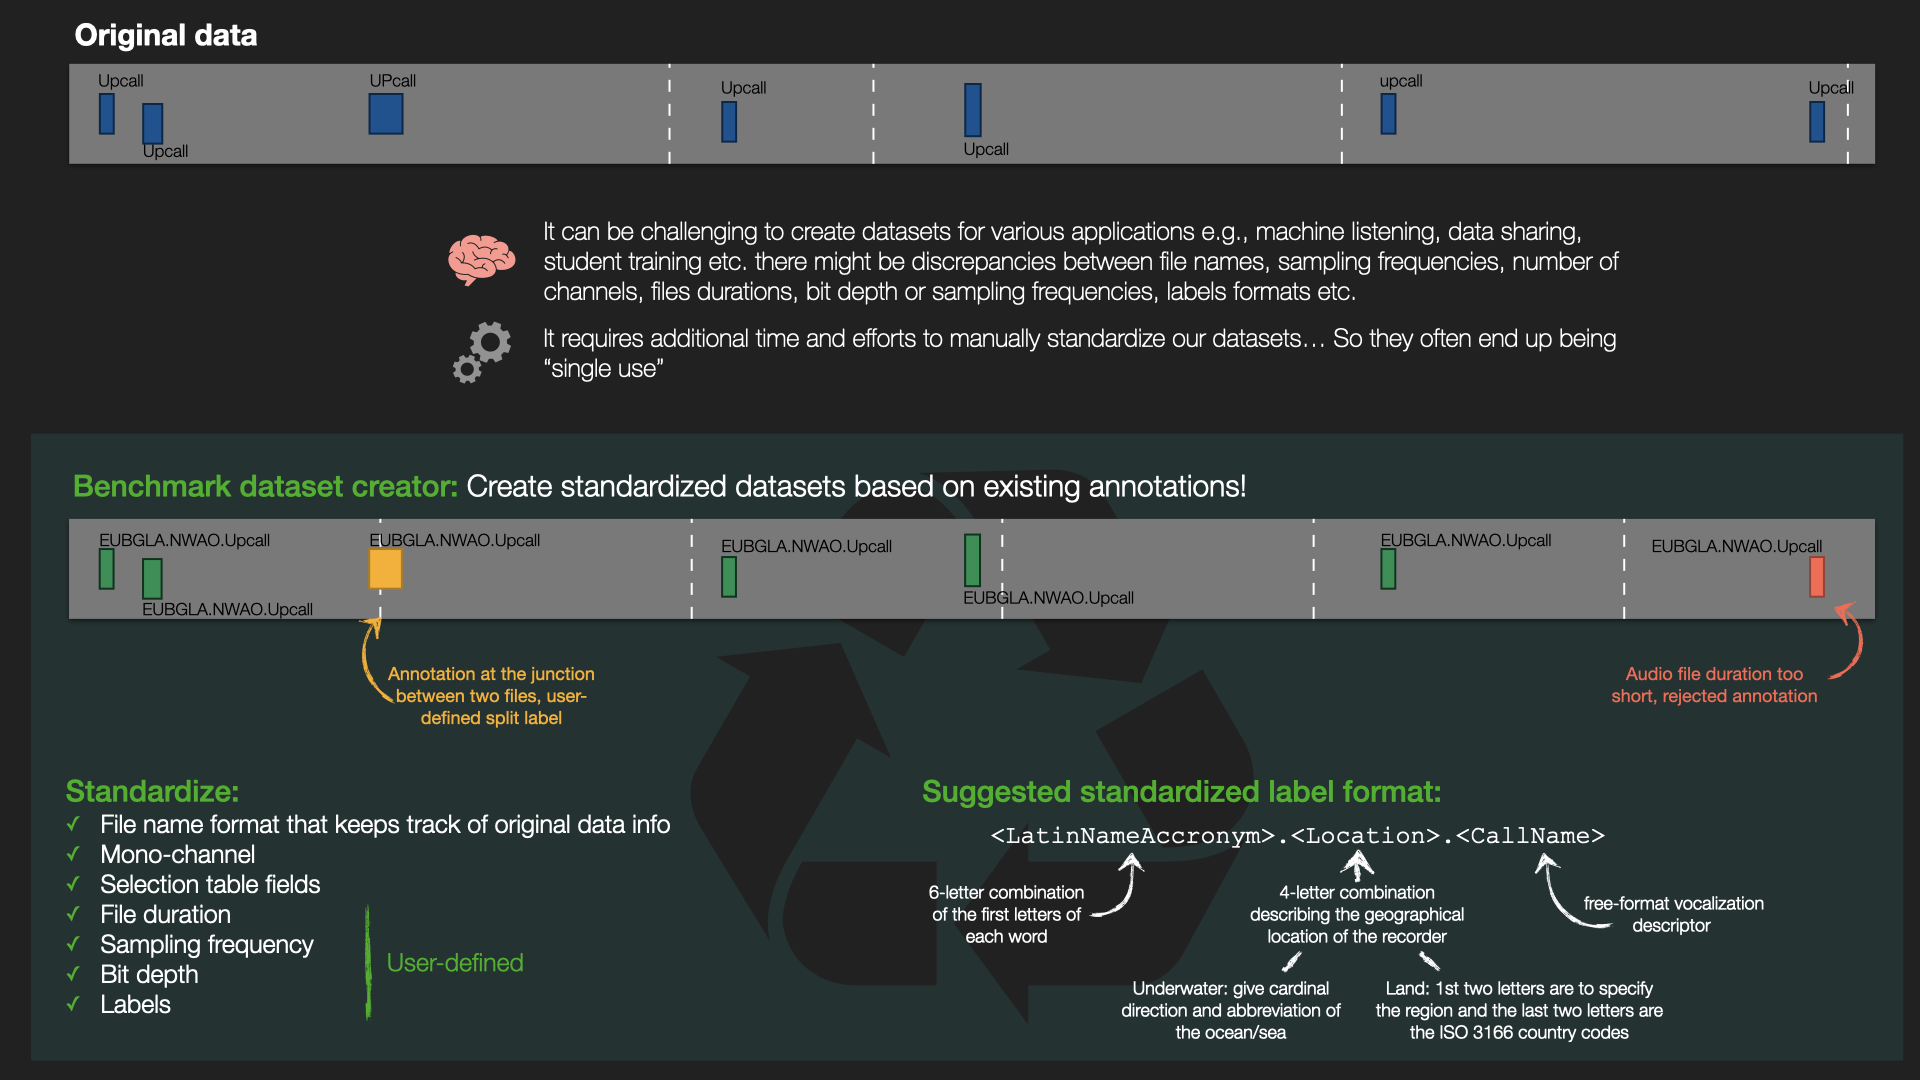

### Necessary information in selection tables
This project uses Raven Pro 1.6 selection tables. Selection tables can either be associated with (1) a single audio file or (2) multiple audio files.
Selection tables, by default, contain the necessary information to draw a time-frequency box around a call, please make sure to have the required following fields, including an annotation column and variables that enable the code to retrieve the audio files:
* 'Begin Time (s)'
* 'End Time (s)'
* 'Low Frequency (Hz)'
* 'High Frequency (Hz)'
* 'Begin Path'
* 'File Offset (s)'
* 'Label'/'Tags'/Other

### Labels 
The following format is our suggested label format: 

`<LatinNameAccronym>.<Location>.<CallName>`

Where 
* `<LatinNameAccronym>` is a 6-letter combination of the first letters of each word,
* `<Location>` a 4-letter combination describing the geographical location of the recorder.
    - If underwater, give cardinal direction and abbreviation of the ocean/sea,
    - If on land, the first two letters specify the region and the last two letters are the ISO 3166 country codes (see https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2#ZZ),

* `<CallName>` free-format vocalization descriptor.


### Outputs
Please refer to the [User-defined parameters](#User-defined-parameters) section to see the details on the output folder architecture. 

</div><div class="alert alert-block alert-info">
<b>This notebook will assist you in creating:</b> 
<ul>
  <li>Benchmark sound files based on user-input specifications</li>
  <li>a corresponding Raven selection table for each sound file, </li>
  <li>a two-column file-matching CSV (as used for Koogu) and,</li>
  <li>a recap annotation CSV file that will match previous datasets, e.g., https://zenodo.org/records/7525805</li>
</ul>
</div>
------------------
Note specific to the Maryland audio data:
I need to first connect to mount W (/Volumes/ag-clo-repnas5.ad.cornell.edu) so U becomes (/Volumes/ag-clo-repnas5.ad.cornell.edu-1), otherwise I need to change the path in Begin Path / the list file!
------------------

### TODO
* OK - Automatically generate a 2-column csv as needed for Koogu, to associate on each line entry the full path of the created audio file and associated selection table. This can be done in the main loop 
* OK - Provide settings guidelines, 
* OK - needs to refine flac bit rate - message CrhisP and BenT. Provide an estimate of the benchmark dataset size based on the user+defined settings. E.g., if the goal is to host them on Zenodo I believe they should be  <50GB
* OK Implement label change
* OK FIX BUG in benchmark_size_estimator
* OK Get the extraction for noise, if longer than a few seconds on both sides create two selections (or do it no matter the selection duration?)
* OK Update the figure
* OK Imporve errors so it stops the program
* OK Add check funcitons for user inputs (export_settings and selection_table_path)
* OK Add comments to the functions, document dependencies

* make as a package - update dependencies
* Generate metada file. --> Look into automatic formats, we can then report methods and user inputs // Maybe that can be a designated spreadsheet other options: https://github.com/kodymoodley/fair-metadata-generator
https://github.com/Materials-Data-Science-and-Informatics/fair-python-cookiecutter
* This <i>could</i> be paralellized, e.g., working on several audio files at once 

* Routine to extract 3s clips for BirdNET embeddings models, with, again user-tunable settings e.g., clip overlap
* Routine for analysis of datasets (like, get the number of call types, duration bandwidth)
* Short intro video

In [1]:
import benchmark_dataset_creator as bc
import pandas as pd

## User-defined parameters <a id='User-defined-parameters'></a>
The following field is a series of user-defined parameters in the form of a [Python dictionary](https://realpython.com/python-dicts/#defining-a-dictionary) (surrounded by curly braces, entries separated by commas, typical entry: `'key word': 'value'`) to create the Benchmark dataset, note that the following fields can be filled in any specific order but must all be present:
* `Original project name`, helps you keep track of the origin of the data, should be written between as a string of characters, which in Python is between quotes `'Project'`. This code will create the folder architecture, please do not end this entry by "/" or "\" and avoid spaces " ".
* `Audio duration (s)` is the chosen export audio file duration for the Benchmark dataset in seconds. Our recommendation is to set it to encompass the vocalization(s) of interest but also some context. What is the minimum duration that would represent the signal's repetition or call/cue rate (with several annotations)?
* `fs (Hz)` is the sampling frequency in Hz, to be set at minima at double the maximum frequency of the signals of interest. If relevant, BirdNET uses fs = 48 kHz (see: [BirdNET Analyzer technical details](https://github.com/kahst/BirdNET-Analyzer?tab=readme-ov-file#technical-details))
* `Bit depth` determines the number of possible amplitude values we can record for each audio sample; for SWIFT units, it is set to 16 bits and for Rockhopper to 24 bits.
* `Export label` defines the name of the label column for the created export Raven selection tables
* `Split export selections` specifies the method when a selection is at the junction between two export audio files if it should be split (True) or not (False). In the case the split is selected, a second value should be entered to specify the minimum duration to report an annotation in the selection table in seconds, e.g., `[True, 3]` or `[False, ]`. If you have hundreds or even tens of selections of your target signals, we would recommend to set this parameter to false. This parameter can be handy if, for example, you selected "long" periods of background noise (long compared to the annotations of signals of interest) that could be split across two audio export files. In that case, you can set the minimun duration to something longer than your signals of interest or to 3 s if you plan to work with BirdNET. Another use case is if you have a very tight selection around your signal of interest (in time) and want even a very small portion of that signal to be labeled.
* `Export folder` is where the data will be saved following this structure (example where `<Project>` is 2013_UnivMD_Maryland_71485_MD0)
```
Export_folder/
│   README.md
│   file001.txt    
│
└───2013_UnivMD_Maryland_71485_MD02/
    │   2013_UnivMD_Maryland_71485_MD02_annotations.csv
    │   2013_UnivMD_Maryland_71485_MD02_audio_seltab_map.csv
    │
    └───audio/
    │   │   <Project>_<OriginalFileName>_<OriginalSamplingFrequency>_<OriginalChannel>_<FileTimeStamp>.flac
    │   │   2013_UnivMD_Maryland_71485_MD02_71485MD02_002K_M11_multi_20150626_031500Z_2kHz_ch03_0600s.flac
    │   │   ...
    │   
    └───annotations/
        │   <Project>_<OriginalFileName>_<OriginalSamplingFrequency>_<OriginalChannel>_<FileTimeStamp>.txt
        │   2013_UnivMD_Maryland_71485_MD02_71485MD02_002K_M11_multi_20150626_031500Z_2kHz_ch03_0600s.txt
        │   ...
```

<div class="alert alert-block alert-info">
<b>Tip:</b> A few fields below, we provide a <b>Benchmark dataset size estimator</b> that can also be used to inform the choice of the user inputs. For example, if you wish to publish your repository on Zenodo, they currenlty accept datasets up to 50GB.
</div>

In [2]:
# User-defined export settings dictionary 
export_settings = {
    'Original project name': '2021_CLOCCB_BermudaPlantBank_S1105', 
    'Audio duration (s)': 300,  
    'fs (Hz)': 8000, 
    'Bit depth': 24,
    'Export label': 'Tags',
    'Split export selections': [True, 1],
    'Export folder': 'benchmark_data'
    }

# Run check on the user-defined entries
bc.check_export_settings(export_settings)

All required fields are filled


The variable `selection_table_path` should be:
* a complete path to a <b>selection table</b> if dealing with a single audio file in total or a project with multiple audio files, e.g. `'SelectionTable/MD03_truth_selections.txt'`
* a path to a <b>folder</b> if dealing with one selection table associated with a single audio file, e.g., `'SelectionTables/'`

In [3]:
selection_table_path = '/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S1112/Atlantic_whales/2021_CLOCCB_BermudaPlantBank_S1105/annotations/'
bc.check_selection_tab(selection_table_path)

selection_table_path is a Folder with 13 .txt Files


## Create the directories

In [4]:
bc.create_path(export_settings)


2021_CLOCCB_BermudaPlantBank_S1105/
    2021_CLOCCB_BermudaPlantBank_S1105_annotations.csv
    2021_CLOCCB_BermudaPlantBank_S1105_audio_seltab_map.csv
    annotations/
        2021_CLOCCB_BermudaPlantBank_S1105_S1105BMU01_250K_S01_RH410_20220104_174420Z_8kHz_ch01_0300s.txt
        2021_CLOCCB_BermudaPlantBank_S1105_S1105BMU01_250K_S01_RH410_20220203_105914Z_8kHz_ch01_2400s.txt
        2021_CLOCCB_BermudaPlantBank_S1105_S1105BMU01_250K_S01_RH410_20211224_083838Z_8kHz_ch01_0900s.txt
        2021_CLOCCB_BermudaPlantBank_S1105_S1105BMU01_250K_S01_RH410_20211224_083838Z_8kHz_ch01_2100s.txt
        2021_CLOCCB_BermudaPlantBank_S1105_S1105BMU01_250K_S01_RH410_20220203_105914Z_8kHz_ch01_1200s.txt
        2021_CLOCCB_BermudaPlantBank_S1105_S1105BMU01_250K_S01_RH410_20220114_214926Z_8kHz_ch01_1500s.txt
        2021_CLOCCB_BermudaPlantBank_S1105_S1105BMU01_250K_S01_RH410_20220203_105914Z_8kHz_ch01_0000s.txt
        2021_CLOCCB_BermudaPlantBank_S1105_S1105BMU01_250K_S01_RH410_20211230_184151Z_8kH

 Y


## Load a selection table

The selection table is loaded as a [Panda dataframe](https://pandas.pydata.org/docs/user_guide/10min.html), which offers lots of visualization tools and resembles R data frames.

In [5]:
selection_table_df = bc.load_selection_table(selection_table_path)
                     
if selection_table_df.empty == False:
    display( selection_table_df)

All required fields are in the selection tables


,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),File Offset (s),Begin Path,Begin File,Species,Call Type
0,1,Spectrogram 2,1,939.346644,953.140604,35.307,89.960,939.3466,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20220113_174851Z.flac,sei,triplet
1,2,Spectrogram 2,1,1031.924582,1034.977343,43.529,85.607,1031.9246,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20220113_174851Z.flac,sei,singlet
0,1,Spectrogram 2,1,1973.962291,1980.520075,28.536,92.379,1973.9623,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20220203_095913Z.flac,sei,doublet
1,2,Spectrogram 2,1,2088.158191,2094.263715,29.987,82.705,2088.1582,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20220203_095913Z.flac,sei,doublet
2,3,Spectrogram 2,1,2224.266250,2230.710969,26.601,86.575,2224.2662,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20220203_095913Z.flac,sei,doublet
...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,Spectrogram 2,1,124.371773,126.633078,32.889,71.581,124.3718,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20211230_194152Z.flac,sei,singlet
1,2,Spectrogram 2,1,289.198404,295.303928,26.601,70.130,289.1984,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20211230_194152Z.flac,sei,doublet
2,3,Spectrogram 2,1,555.195932,561.414520,28.536,66.261,555.1959,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20211230_194152Z.flac,sei,doublet
3,4,Spectrogram 2,1,654.105523,656.592959,26.601,70.614,654.1055,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20211230_194152Z.flac,sei,singlet


In [6]:
# User-defined label key, should be in the Selection table keys displaid above
label_key = 'Call Type'

## Test the selection table and estimate the size of the benchmark dataset

In [7]:
# Remove duplicates (e.g., if we have both the spectrogram and waveform view)
selection_table_df.drop_duplicates(subset='Begin Time (s)', keep="last");

# Estimate the size of the dataset
bc.benchmark_size_estimator(selection_table_df, export_settings, label_key)

All files can be divided into 11 x 300-s clips
File size are estimated with a flac compression factor of 50% which may vary depending on the file.
Estimated file size ... 4 MB
 > Estimated Benchmark dataset size ... 223 MB


## Check and update the labels

In [8]:
# Get a list of unique labels from the selection table
unique_labels = selection_table_df[label_key].unique()

# Print the list of unique labels
print('Unique label list:')
for lab in unique_labels:
    print(lab)

Unique label list:
triplet
singlet
doublet
B
C
D


If you wish to replace labels run the cell below where `new_labels_dict` is a [Python dictionary](https://realpython.com/python-dicts/#defining-a-dictionary) connecting:
> the orignal label on the left || the new label on the right

both are strings, i.e., text between single quotes for example:
```
new_labels_dict = {
    'NARW': 'EUBGLA.NWAO.Upcall',
    'BW': 'BALMUS.NWAO.Dcall'
}
```
Note: if the left side does not contain any of your original label list, no changes will be made.

In [9]:
# New label dictionnary
new_labels_dict = {
    'NARW': 'EUBGLA.NWAO.Upcall',
    'na': 'BALMUS.NWAO.Dcall',
}

# Swap the labels
selection_table_df = bc.update_labels(selection_table_df, new_labels_dict, label_key)

Skipping: Original label NARW not found in the selection table
Skipping: Original label na not found in the selection table
New unique label list:
triplet
singlet
doublet
B
C
D


## Create the Benchmark dataset

We use selection to refer to the time boundaries of a row in a selection table and clip/export clip when referring to the longer chunck of data that will become the benchmark audio data.

### Technical notes
* The data is loaded and resample with Librosa where the very high quality sox method is implemented. This method does not require to apply a low-pass filter to the data
* Bit depth soundfile only supports: `sf.available_subtypes('FLAC')` helpful GIT: https://github.com/mgeier/python-audio/blob/master/audio-files/audio-files-with-pysoundfile.ipynb
    * 'PCM_S8': 'Signed 8 bit PCM',
    * 'PCM_16': 'Signed 16 bit PCM',
    * 'PCM_24': 'Signed 24 bit PCM'
    So we need to use another method to create 32 bit files -> Max is 24, we're fine.
* At the moment only flac files are supported for the export. Is there a need for wav files? Koogu ok with flac, what about BirdNET?
    


In [10]:
import time
start_time = time.time()

bc.benchmark_creator(selection_table_df, export_settings, label_key)

print(f'The Benchmark Dataset Creator took {time.time() - start_time} s to run')

  0%|          | 0/13 [00:00<?, ?it/s]

The Benchmark Dataset Creator took 16.28528380393982 s to run
